In [18]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [12]:
# load datasets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# normalization
train_images = train_images / 255.
test_images = test_images / 255.

In [32]:
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype('float32')

In [33]:
pairs_train, labels_train = make_pairs(train_images, train_labels)
pairs_test, labels_test = make_pairs(test_images, test_labels)

In [45]:
from tensorflow.keras.layers import Flatten, Input, Dense, Dropout
from tensorflow.keras.models import Model

def base_network():
    input = Input(shape=(28, 28), name='base_input')
    x = Flatten(name='flatten_input')(input)
    x = Dense(128, activation='relu', name='first_base_dense')(x)
    x = Dropout(0.1, name='first_dropout')(x)
    x = Dense(128, activation='relu', name='second_base_dense')(x)
    x = Dropout(0.1, name='second_dropout')(x)
    x = Dense(128, activation='relu', name='third_base_dense')(x)
    return Model(inputs=input, outputs=x)

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))

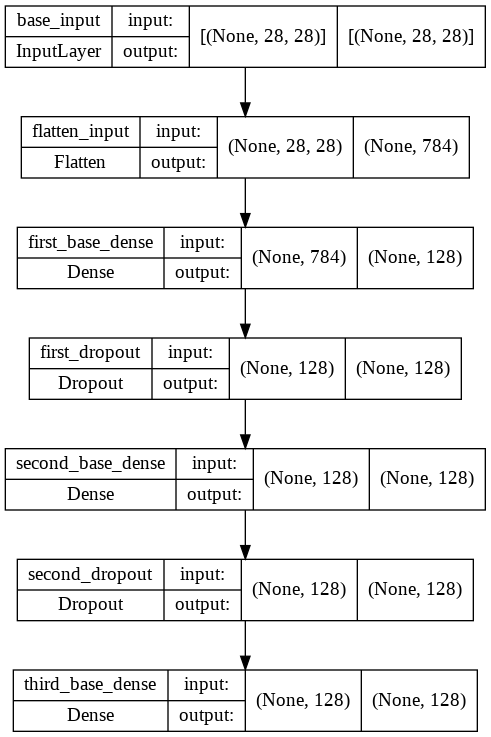

In [46]:
from tensorflow.keras.utils import plot_model
base_model = base_network()
plot_model(base_model, show_shapes=True, show_layer_names=True)

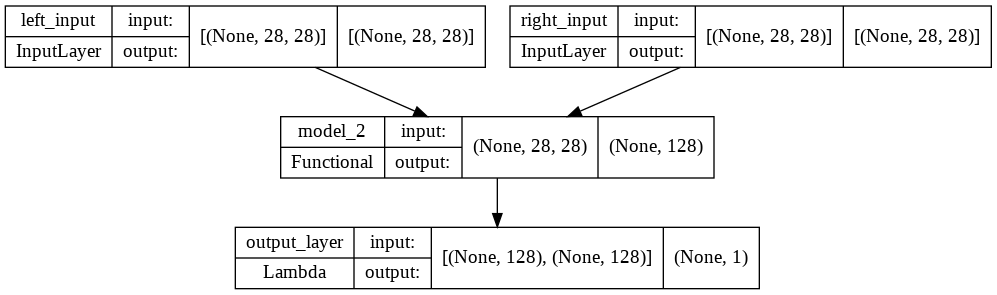

In [47]:
from tensorflow.keras.layers import Lambda
input_a = Input(shape=(28,28,), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(28,28,), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])
# define model
model = Model([input_a, input_b], output)
plot_model(model, show_shapes=True, show_layer_names=True)

In [48]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss
 
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([pairs_train[:,0], pairs_train[:,1]], labels_train, epochs=20, batch_size=128, validation_data=([pairs_test[:,0], pairs_test[:,1]], labels_test))

Epoch 1/20
938/938 [==============================] - 10s 10ms/step - loss: 0.1131 - val_loss: 0.0884
Epoch 2/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0805 - val_loss: 0.0782
Epoch 3/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0718 - val_loss: 0.0707
Epoch 4/20
938/938 [==============================] - 12s 13ms/step - loss: 0.0669 - val_loss: 0.0682
Epoch 5/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0634 - val_loss: 0.0698
Epoch 6/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0613 - val_loss: 0.0652
Epoch 7/20
938/938 [==============================] - 9s 10ms/step - loss: 0.0597 - val_loss: 0.0653
Epoch 8/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0581 - val_loss: 0.0653
Epoch 9/20
938/938 [==============================] - 9s 9ms/step - loss: 0.0569 - val_loss: 0.0637
Epoch 10/20
938/938 [==============================] - 8s 9ms/step - loss: 0.0559 - val_loss: 

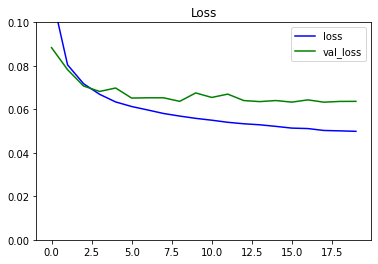

In [50]:
plt.title('Loss')
plt.ylim(0,0.1)
plt.plot(history.history['loss'],color='blue',label='loss')
plt.plot(history.history['val_' + 'loss'],color='green',label='val_' + 'loss')
plt.legend()

In [54]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
        if predictions[i] < 0.2: t.set_color('green') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

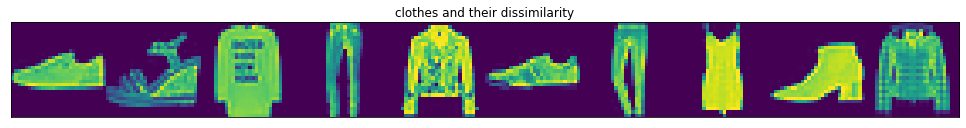

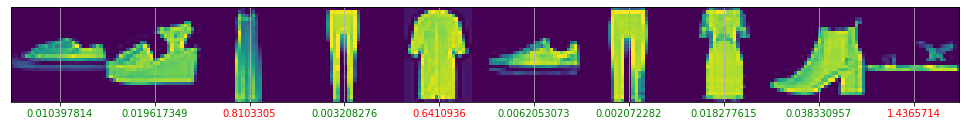

In [55]:
predictions = np.squeeze(model.predict([pairs_test[:,0], pairs_test[:,1]]))
indexes = np.random.choice(len(predictions), size=10)

display_images(pairs_test[:, 0][indexes], pairs_test[:, 1][indexes], predictions[indexes], labels_test[indexes], "clothes and their dissimilarity", 10)